Four Classes Expanding and One Class Fixed. Bidimensional.
100 batches of 1645 instances



METHOD: Static lp as classifier
Execution time:  2.536215742800067
Average error: 1.559400000000025
Average macro-F1: 0.9838351213741743
Average micro-F1: 0.9846
Acurácia Média:  98.44059999999998
Desvio Padrão:  0.4346833790243192
Variância:  0.18894963999999995


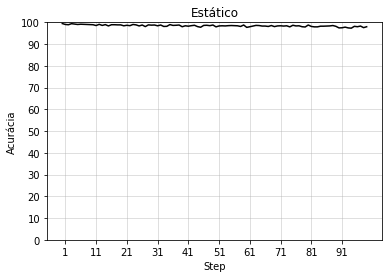

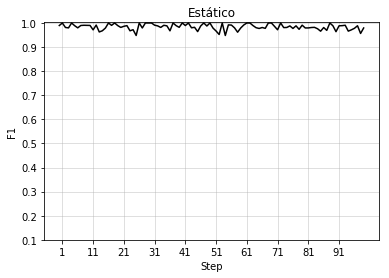




METHOD: Sliding lp as classifier
Execution time:  1.9037580945692634
Average error: 11.759500000000003
Average macro-F1: 0.8853698337779027
Average micro-F1: 0.8793
Acurácia Média:  88.2405
Desvio Padrão:  9.92110844361657
Variância:  98.42839274999999


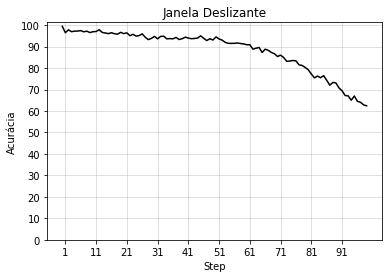

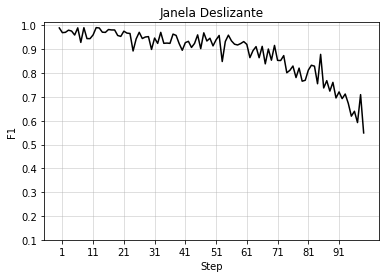




METHOD: Incremental lp as classifier
Execution time:  71.51905172593432
Average error: 1.2107000000000028
Average macro-F1: 0.9882841868036932
Average micro-F1: 0.9888000000000001
Acurácia Média:  98.7893
Desvio Padrão:  0.4320862298199287
Variância:  0.18669851000000026


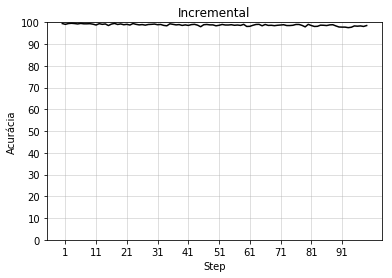

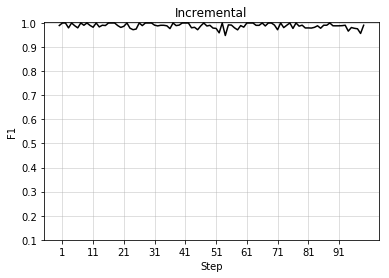




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  15.620673267868696
Average error: 1.8519000000000005
Average macro-F1: 0.9803942342102829
Average micro-F1: 0.9808999999999999
Acurácia Média:  98.1481
Desvio Padrão:  0.4522337780396322
Variância:  0.20451538999999933


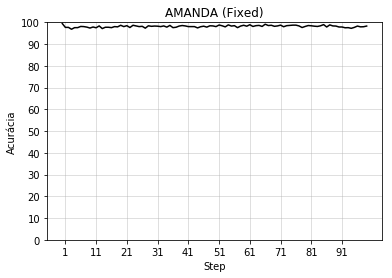

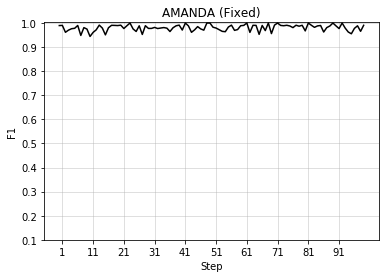




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.31 | Std keeping percentage=0.19
Execution time:  15.273353771203887
Average error: 2.0220000000000056
Average macro-F1: 0.9787363330053926
Average micro-F1: 0.9793999999999999
Acurácia Média:  97.978
Desvio Padrão:  0.5439595573202105
Variância:  0.2958919999999994


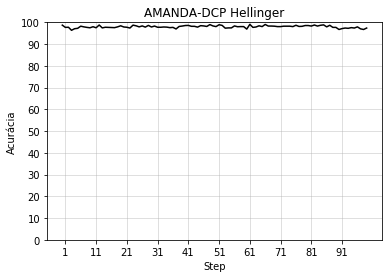

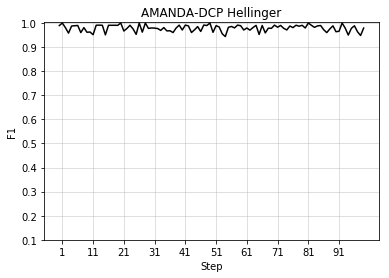




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.18 | Std keeping percentage=0.08
Execution time:  14.761117018679286
Average error: 2.356800000000021
Average macro-F1: 0.9763691028684608
Average micro-F1: 0.9771
Acurácia Média:  97.64319999999998
Desvio Padrão:  0.8392852673555032
Variância:  0.7043997599999986


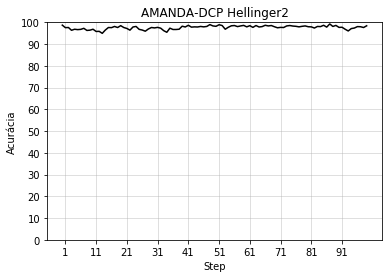

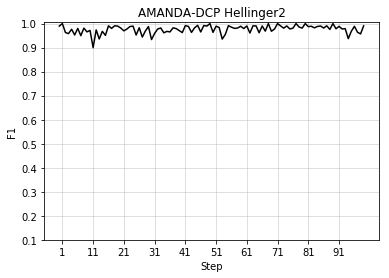




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.10 | Std keeping percentage=0.01
Execution time:  14.896187353297847
Average error: 2.019999999999996
Average macro-F1: 0.97852381071011
Average micro-F1: 0.9789999999999999
Acurácia Média:  97.98
Desvio Padrão:  0.5029274301527015
Variância:  0.25293600000000044


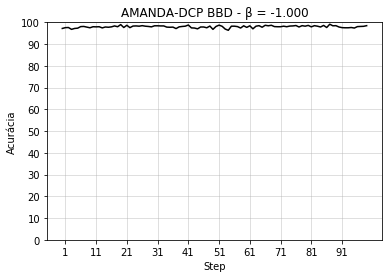

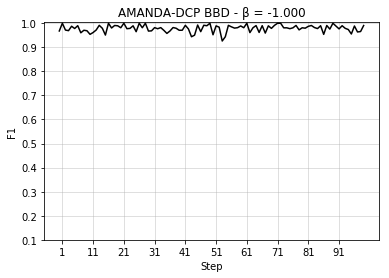

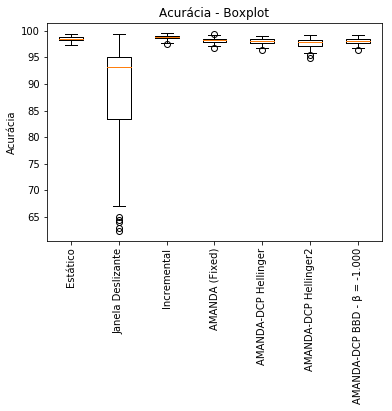

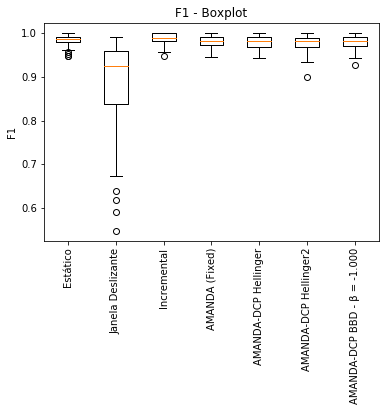

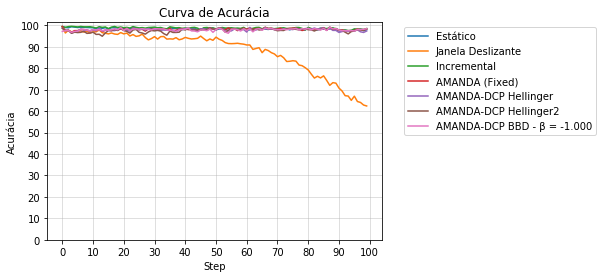

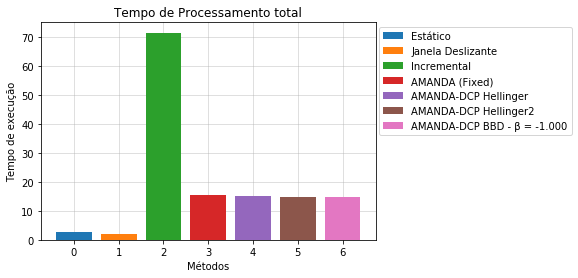

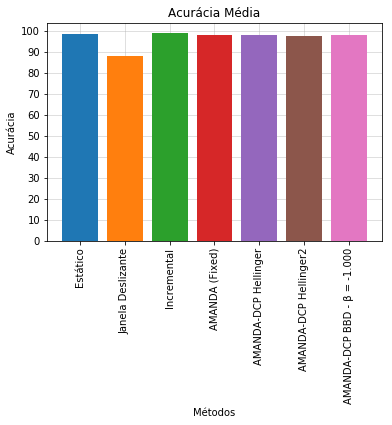

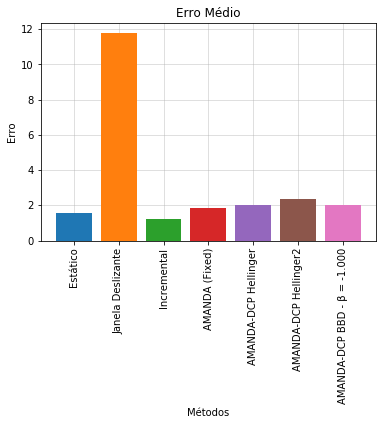

Pos 7 - Redução do Erro (Janela Deslizante):-10.361680038520673
Pos 1 - Redução do Erro (Incremental):0.354223765397633
Pos 3 - Redução do Erro (AMANDA (Fixed)):-0.2971334997957912
Pos 5 - Redução do Erro (AMANDA-DCP Hellinger):-0.46992805813859395
Pos 6 - Redução do Erro (AMANDA-DCP Hellinger2):-0.810031633289513
Pos 4 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):-0.46789637608869833


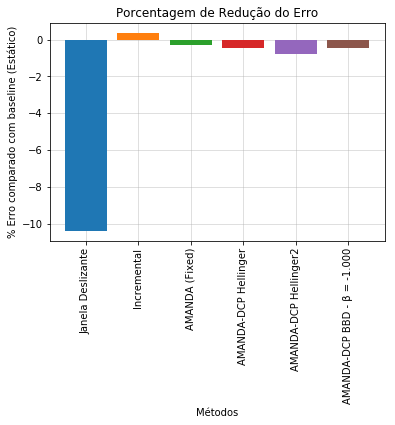

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.load4CE1CF(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 2, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 2, 0.85, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - DCP ORIGINAL)
    experiments[4] = Experiment(amanda_dynamic, 3, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 3, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    betas = [-1]
    bestK = [8]    
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
    # Proposed method 4 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 3, None, "kde", sslClassifier, 'HDDDM')

    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 5)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '4CE1CF', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()